一、数据读取

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('ab_data.csv')
print(data.head())

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1


二、数据清洗

In [3]:
print('数据行数：', data.shape[0])
print('独立用户数：', data.user_id.nunique())

数据行数： 294478
独立用户数： 290584


In [4]:
#发现有重复用户，查看详情
print(data[data.user_id.duplicated(keep=False)].sort_values(by = 'user_id').head(10))

user_id                   timestamp      group landing_page  converted
230259   630052  2017-01-17 01:16:05.208766  treatment     new_page          0
213114   630052  2017-01-07 12:25:54.089486  treatment     old_page          1
22513    630126  2017-01-14 13:35:54.778695  treatment     old_page          0
251762   630126  2017-01-19 17:16:00.280440  treatment     new_page          0
183371   630137  2017-01-20 02:08:49.893878    control     old_page          0
11792    630137  2017-01-22 14:59:22.051308    control     new_page          0
207211   630320  2017-01-07 18:02:43.626318    control     old_page          0
255753   630320  2017-01-12 05:27:37.181803  treatment     old_page          0
96929    630471  2017-01-07 02:14:17.405726    control     new_page          0
110634   630471  2017-01-23 01:42:51.501851    control     old_page          0


In [5]:
#查看group和landing_page不匹配的数量：
mismatch = ((data['group'] == 'treatment') != (data['landing_page'] == 'new_page'))
print('不匹配数：', mismatch.sum())

#将不匹配数剔除筛选
match_df = data[~mismatch].copy()  # ~表示按位取反

不匹配数： 3893


In [6]:
print('数据行数：', match_df.shape[0])
print('独立用户数：', match_df.user_id.nunique())

数据行数： 290585
独立用户数： 290584


In [7]:
#仍旧有重复的用户id，查看：
print(match_df[match_df.user_id.duplicated(keep=False)])

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [8]:
#该用户两个时间点都未转化，仅保留最近的1条信息：
match_df = match_df.drop_duplicates(subset=['user_id'], keep='last')

In [9]:
#检查缺失值：无缺失值
print(match_df.isnull().sum())

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [10]:
#再看看收到新页面的用户占比多少： 得到的结果是0.50，收到新版和旧版页面的用户占比还是很接近的。
print(match_df[match_df.landing_page=="new_page"].shape[0]/match_df.shape[0])

0.5000619442226688


三、假设检验

接下来进入假设检验阶段。实际上是判断新旧页面的转化情况是否有显著差异，备择假设为新页面的转化情况优于旧页面。用转化率衡量转化情况。

下面尝试三种方法：1.公式直接计算 2.python函数计算 3.蒙特卡洛法模拟

In [11]:
# 旧版、新版用户数
n_old = match_df.query('group=="control"').shape[0]
n_new = match_df.query('group=="treatment"').shape[0]
# 旧版、新版转化用户数
convert_old = match_df.query('group=="control" & converted==1').shape[0]
convert_new = match_df.query('group=="treatment" & converted==1').shape[0]
# 旧版、新版均值，即转化率
p_old = match_df[match_df.group=="control"].converted.mean()
p_new = match_df[match_df.group=="treatment"].converted.mean()
## 旧版、新版标准差
std_old = match_df[match_df.group=="control"].converted.std()
std_new = match_df[match_df.group=="treatment"].converted.std()
print('旧版总用户数:', n_old, '旧版转化用户数:', convert_old, '旧版转化率:', p_old,'旧版标准差:',std_old)
print('新版总用户数:', n_new, '新版转化用户数:', convert_new, '新版转化率:', p_new,'新版标准差:',std_new)

旧版总用户数: 145274 旧版转化用户数: 17489 旧版转化率: 0.1203863045004612 旧版标准差: 0.32541384592046235
新版总用户数: 145310 新版转化用户数: 17872 新版转化率: 0.12299222352212512 新版标准差: 0.3284294121886301


1.公式直接计算

In [12]:
#计算旧版和新版的平均转化率：
p_all = match_df.converted.mean()
print('样本的总转化率', p_all)

#计算检验统计量z：
z = (p_old - p_new)/ np.sqrt(p_all*(1 - p_all)*( 1/n_old + 1/n_new))
print('检验统计量z:', z)

from scipy.stats import norm
z_alpha = norm.ppf(0.05) # 若为双侧，则norm.ppf(0.05/2)
print('临界值:', z_alpha)

#对比平均值时，衡量差异效应大小的常见标准之一是Cohen's d，中文一般译作科恩d值
s = np.sqrt(((n_old - 1)* std_old**2 + (n_new - 1)* std_new**2 ) / (n_old + n_new - 2))
d = (p_old - p_new) / s
print('Cohen\'s d为：', d)

#z<z_alpha,拒绝零假设。
#效应量 Cohen's d = -0.0080，很小。
#这说明两者虽有显著性水平5%时统计意义上的显著差异，但差异的效应量很小。

样本的总转化率 0.12168942543292129
检验统计量z: -2.1484056695589
临界值: -1.6448536269514729
Cohen's d为： -0.007970992391336005


2.statsmodels包计算

In [13]:
#前面根据案例实际，我们用的是两个比率的Z检验函数proportion.proportions_ztest，输入的是两组各自的总数和转化数,得到的z值和前面计算的完全相同，拒绝零假设。
#如果是一般性的Z检验，可以用weightstats.ztest函数，直接输入两组的具体数值,可以看到计算结果很接近，但有差异。因为非比率的Z检验是不计算联合估计的。

import statsmodels.stats.proportion as sp
z_score, p_value = sp.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller') # alternative='smaller'代表左尾
print('检验统计量z:', z_score, '，p值:', p_value)

import statsmodels.stats.weightstats as sw
z_score1, p_value1 = sw.ztest(match_df.query('landing_page=="old_page"')['converted'], match_df.query('landing_page=="new_page"')['converted'],
                        alternative='smaller')
print('检验统计量z:', z_score1, '，p值:', p_value1)

检验统计量z: -2.1484056695589 ，p值: 0.015840771394875417
检验统计量z: -2.148415338961362 ，p值: 0.01584038766094882


3. 蒙特卡洛法模拟
蒙特卡洛法其实就是模拟法，用计算机模拟多次抽样，获得分布。这种方法很直观，能帮助我们理解分布、p值、 分位数等概念。

p_all: 0.12168942543292129
ab_data.csv样本的转化率差值: -0.002605919021663919


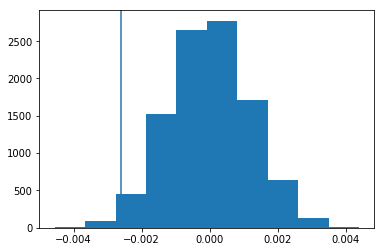

0.014


'现在图中的直方图是，若旧版和新版的转化率相等，随机10000次，两者的差值的分布。因为次数够多，根据大数定律，近似于真实的分布。\n竖线左侧的面积占比，即发生“竖线及竖线左侧极端情况”（diff<=-0.0026）的可能性。也就是说，ab_data.csv这个样本，在旧版和新版转化率相等的情况下，有可能出现，但出现的可能性很小。所以反推出，旧版和新版的转化率很有可能不相等。'

In [14]:
#样本的总转化率
p_all = match_df.converted.mean()
print('p_all:', p_all)

#模拟方式：以p_all为新旧版共同的转化率，即取 p_all=p_old=p_new，分别进行n_old次和n_new次二点分布的抽样，使模拟的样本大小同ab_data.csv中的样本大小相同；按照如上方式进行10000模拟，并计算出每次模拟得到的新旧版转化率差值，将其存储在diffs中：
diffs=[]
for i in range(10000):
    p_new_page= np.random.choice(2,size=n_new,p=[1-p_all,p_all]).mean()
    p_old_page = np.random.choice(2,size=n_old,p=[1-p_all,p_all]).mean()
    diffs.append(p_old_page - p_new_page)



# 计算ab_data.csv样本的转化率差值
match_diff = match_df[match_df.landing_page=="old_page"]['converted'].mean()-match_df[match_df.landing_page=="new_page"]['converted'].mean()
print('ab_data.csv样本的转化率差值:', match_diff)



#在图上将模拟得到的diffs绘制为直方图，将ab_data.csv中样本的转化率差值绘制为竖线：
diffs = np.array(diffs)
plt.hist(diffs)
plt.axvline(match_diff)
plt.show()

#在diffs列表的数值中，有多大比例小于ab_data.csv中观察到的转化率差值，每次运行比例都不一样，但都接近于方法2中的P值
print((diffs < match_diff).mean())


'''现在图中的直方图是，若旧版和新版的转化率相等，随机10000次，两者的差值的分布。因为次数够多，根据大数定律，近似于真实的分布。
竖线左侧的面积占比，即发生“竖线及竖线左侧极端情况”（diff<=-0.0026）的可能性。也就是说，ab_data.csv这个样本，在旧版和新版转化率相等的情况下，有可能出现，但出现的可能性很小。所以反推出，旧版和新版的转化率很有可能不相等。'''